# Imputing Missing Data

* Topic: Imputation
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Clarke, Kaustav Das
* Version: 3.0.1

In this notebook we investigate ways for dealing with missing data using Scikit-Learn's imputation routines or native Pandas methods. There are two main routines we will discuss: `SimpleImputer` and `KNNImputer`. We will only discuss imputing continuous, numerical values; for imputing categorical values possible approaches are using the mode or `KNNImputer`.

We will use the [Pima Indians Diabetes Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database), which can be downloaded from [Monash Gitlab](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Imputation/pima_indians_diabetes.csv). This aims to predict whether the patient has diabetes from a number of diagnostic measurements. All patients are females of Pima Indian heritage, who are at least 21 years old.

It may be tempting to handle missing data by deleting that entry. However, that means losing valuable data which contributes to the training of your model. Often a better approach is to impute the data, i.e., infer the missing data from the existing observations.

## Contents

* Introduction
* Preliminary analysis
* Exercises

## Introduction

We first import the standard libraries and the csv file.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pima = pd.read_csv("pima_indians_diabetes.csv")

We can now view a random sample of the data. In the columns `BloodPressure`, `SkinThickness` and `Insulin` there are values of 0, which are clearly not possible. This is indicative of missing values.

In [2]:
pima.sample(15)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
571,2,130,96,0,0,22.6,0.268,21,0
212,7,179,95,31,0,34.2,0.164,60,0
259,11,155,76,28,150,33.3,1.353,51,1
664,6,115,60,39,0,33.7,0.245,40,1
96,2,92,62,28,0,31.6,0.130,24,0
601,6,96,0,0,0,23.7,0.190,28,0
205,5,111,72,28,0,23.9,0.407,27,0
709,2,93,64,32,160,38.0,0.674,23,1
140,3,128,78,0,0,21.1,0.268,55,0
373,2,105,58,40,94,34.9,0.225,25,0


This can be investigated further by displaying the descriptive statistics, for which it is apparent that `Glucose` and `BMI` also have unrealistic values of 0. A value of 0 for `Pregnancies` however is a physically realistic value.

In [3]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


To see how many 0 values there are in these fields, we can sum the number of rows which match this criteria. The two fields with the most missing values are `SkinThickness` and `Insulin`. 

In [4]:
(pima[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Since 0 is a valid entry in `Pregnancies` and `Outcome`, we mark the missing values in these five fields as NaN (not a number). This is the default for missing values for the sklearn imputation routines. Marking the values as NaN gives the same number of missing entries as previously.

In [5]:
# Use the .replace method in order to replace 0 values with NaN

pima[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = \
    pima[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

pima.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

## Preliminary analysis

We now set up a simple k-Nearest Neighbours model to investigate the effect of a selection of different imputation methods on the accuracy, precision and recall. Here the recall is the most significant metric, as we want to minimize false negatives (has diabetes, but not predicted). The function below creates a k-Nearest Neighbours model for the diabetes data and prints the metrics. The target variable will be `Outcome`.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

def kNN_model(pimadf):
    Xf = pimadf.drop(columns=['Outcome'])
#     Yf = np.ravel(pimadf[['Outcome']])
    Yf = pimadf[['Outcome']]
    
    X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state = 0) 
    kNN = KNeighborsClassifier(n_neighbors = 5)
    kNN.fit(X_train, Y_train) # fit the data to the model
    Y_pred = kNN.predict(X_test) # Predict the target values from the test feature data
    acc = accuracy_score(Y_test,Y_pred) 
    prec = precision_score(Y_test,Y_pred) 
    rec = recall_score(Y_test,Y_pred) 
    print("\n")
    print(f'Testing scores are: accuracy {acc:.3f}, precision {prec:.3f}, recall {rec:.3f}')

## Dropping missing data

The first method to handle missing data is to drop all rows which have a missing value. This results in approximately half of the dataset being dropped. For this data one of the most important features is `Insulin`, which unfortunately is the feature with the most missing values. 

In [7]:
pima_drop = pima.copy()
pima_drop.dropna(inplace=True)
print('Dropping rows')
print("\n")
print('Shape of dropped values array',pima_drop.shape)
print('Shape of original array',pima.shape)

kNN_model(pima_drop)

Dropping rows


Shape of dropped values array (392, 9)
Shape of original array (768, 9)


Testing scores are: accuracy 0.747, precision 0.632, recall 0.480


For reference we can plot the distribution of `Insulin` and `SkinThickness` to investigate how different imputation methods affect this. For the other features with missing values the distributions will not be significantly affected, and the exact imputation method probably is not critical to the model.

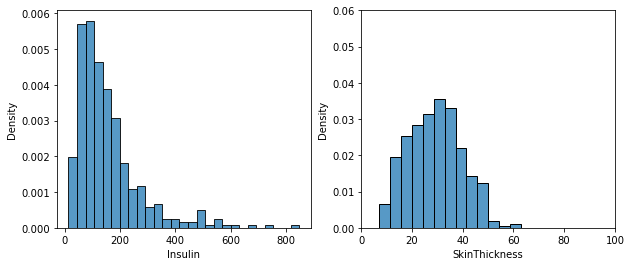

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.histplot(pima_drop, x="Insulin", stat="density", ax = axes[0])
sns.histplot(pima_drop, x="SkinThickness", stat="density", ax = axes[1])
axes[1].set_xlim(0,100)
axes[1].set_ylim(0,0.06);

## Simple Imputation

The first class of imputation methods we will discuss is called 'Simple Imputation'. This is where we simply replace the missing data with a constant (usually 0) or some descriptive statistic, e.g., mean, median, mode. Here we will consider imputation with the mean as well as the median.

### Imputing with the mean or median

Replacing the missing values with the mean or the median now results in an increase of all the metrics of the model. This is understandable, as replacing the missing values with a constant results in the reduction of the variance of the feature. We will use the pandas .fillna method, however this can also be achieved through SciKit-Learn.

In [9]:
pima_mean = pima.copy()
pima_mean.fillna(pima_mean.mean(), inplace=True)

print('Imputation using mean')
kNN_model(pima_mean)

Imputation using mean


Testing scores are: accuracy 0.753, precision 0.596, recall 0.596


In [10]:
pima_median = pima.copy()
pima_median.fillna(pima_median.median(), inplace=True)

print('Imputation using median')
kNN_model(pima_median)

Imputation using median


Testing scores are: accuracy 0.766, precision 0.622, recall 0.596


This reduction in variance can be clearly seen by plotting the distributions of the mean and median datasets. For both, the plots are now dominated by a single peak; this is due to the all missing data being filled in by a common value.

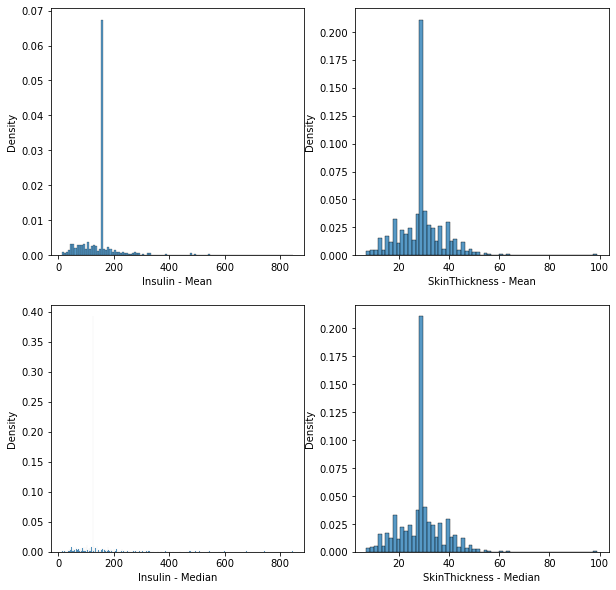

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(pima_mean, x="Insulin", stat="density", ax = axes[0,0])
axes[0,0].set_xlabel('Insulin - Mean')
sns.histplot(pima_median, x="Insulin", stat="density", ax = axes[1,0])
axes[1,0].set_xlabel('Insulin - Median')
sns.histplot(pima_mean, x="SkinThickness", stat="density", ax = axes[0,1])
axes[0,1].set_xlabel('SkinThickness - Mean')
sns.histplot(pima_median, x="SkinThickness", stat="density", ax = axes[1,1])
axes[1,1].set_xlabel('SkinThickness - Median');

## k-Nearest Neighbours imputer

Another class of imputation methods is 'machine learning imputation'. We will only consider one machine learning imputation method, namely the k-Nearest Neighbours imputer. This iterates through all the missing values, treating each one as a label, and then finds the corresponding label of its k-Nearest Neighbours. This will be affected by the distance metric that is used, the number of neighbours and the order that the features are imputed. In this case we use the default values and 5 neighbours.

The accuracy is slightly higher than for the dataset where we dropped the rows, and similar to using the mean and median.

In [12]:
from sklearn.impute import KNNImputer

pima_knnn = pima.copy()
X = pima_knnn.iloc[:,0:8]
Xm = X.mean()
Xs = X.std()
X = (X-X.mean())/X.std() #Normalise the data
Xt = KNNImputer(n_neighbors=5).fit_transform(X)
pima_knnn.iloc[:,0:8] = Xt

print('Imputation using k-Nearest Neighbours')
pima_knnn.iloc[:,0:8] = Xs*pima_knnn.iloc[:,0:8]+Xm
kNN_model(pima_knnn)

Imputation using k-Nearest Neighbours


Testing scores are: accuracy 0.773, precision 0.625, recall 0.638


Plotting the distributions shows that the `KNNImputer` gives a imputation which replicates the original data better than any of the other simple imputation methods we considered.

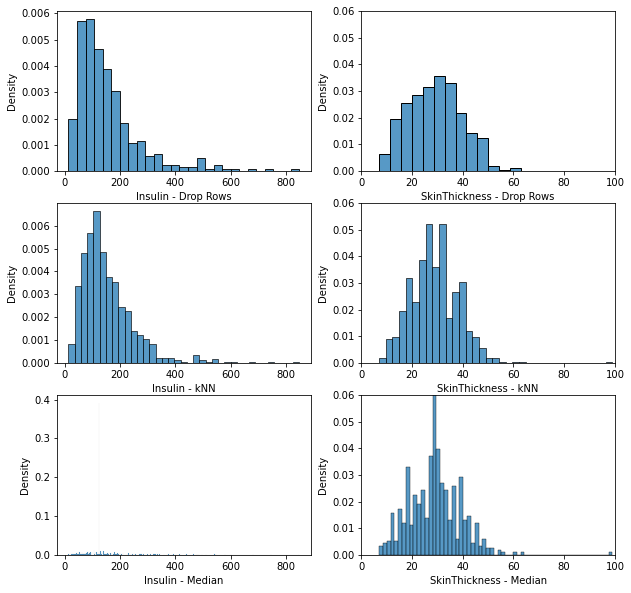

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10,10))

sns.histplot(pima_drop, x="Insulin", stat="density", ax = axes[0,0])
axes[0,0].set_xlabel('Insulin - Drop Rows')
sns.histplot(pima_knnn, x="Insulin", stat="density", ax = axes[1,0])
axes[1,0].set_xlabel('Insulin - kNN')
sns.histplot(pima_median, x="Insulin", stat="density", ax = axes[2,0])
axes[2,0].set_xlabel('Insulin - Median')
sns.histplot(pima_drop, x="SkinThickness", stat="density", ax = axes[0,1])
axes[0,1].set_xlabel('SkinThickness - Drop Rows')
axes[0,1].set_xlim(0,100)
axes[0,1].set_ylim(0,0.06)
sns.histplot(pima_knnn, x="SkinThickness", stat="density", ax = axes[1,1])
axes[1,1].set_xlabel('SkinThickness - kNN')
axes[1,1].set_xlim(0,100)
axes[1,1].set_ylim(0,0.06)
sns.histplot(pima_median, x="SkinThickness", stat="density", ax = axes[2,1])
axes[2,1].set_xlabel('SkinThickness - Median')
axes[2,1].set_xlim(0,100)
axes[2,1].set_ylim(0,0.06);

## SciKit-Learn Simple Imputer 

Instead of using the fillna method from pandas, it is possible to instead use SciKit-Learn's function `SimpleImputer` in order to impute data via descriptive statistics, e.g., the mean, median, mode etc. An example of imputation using the mean through SimpleImputer is the following.

In [14]:
from sklearn.impute import SimpleImputer

pima_simple = pima.copy()
X = pima_simple.iloc[:,0:8]
Xt = SimpleImputer(strategy = 'mean').fit_transform(X)
pima_simple.iloc[:,0:8] = Xt

print('Imputation using mean')
kNN_model(pima_simple)


Imputation using mean


Testing scores are: accuracy 0.753, precision 0.596, recall 0.596


## Summary

- Missing data must be dealt with by either removal or by imputation, i.e., estimating and filling in missing values.
- Dropping observations (rows) which have missing values can lead to a catastrophic reduction in data; depending on the context this may or may not be justified (e.g., if imputation cannot be achieved reliably).
- Dropping features (columns) which have many missing values is often justified, depending on how much is missing, and how important that feature is for the task at hand.
- Simple imputation involves replacing missing values with a constant or descriptive statistic of the feature, e.g., the mean, median, mode. However, this can lead to a drastic shift in the distribution of data, and hence the variance of the data.
- Machine learning algorithms can also be utilised for imputation and are much more sophisticated than their simple imputator counterparts. The kNN imputer is sufficient for many purposes. 